# Required packages
Make sure to install all the below packes via pip and download the necessary models:
- python -m spacy download nl_core_news_sm

In [1]:
#Data Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Data Preprocessing and Feature Engineering
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

from googletrans import Translator
from langdetect import detect
import csv
import pyspark
from pyspark.sql import SQLContext, functions as F
from pyspark.sql.functions import udf, split
from pyspark.sql.types import StringType, IntegerType, StructField, StructType, ArrayType

import spacy

In [2]:
sc = pyspark.SparkContext('local[*]')
sql_sc = SQLContext(sc)

# Loading the dataset

In [3]:
schema = [
    StructField("tweet_id", StringType(), True),
    StructField("created_at", StringType(), True),
    StructField("name", StringType(), True),
    StructField("text", StringType(), True),
    StructField("location", StringType(), True),
    StructField("tags", StringType(), True),
    StructField("label", IntegerType(), True)]

test_tweets = sql_sc.read.csv(
    "./test_data.csv", header=True, mode="DROPMALFORMED", schema = StructType(schema)
)
test_tweets.printSchema()

root
 |-- tweet_id: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- name: string (nullable = true)
 |-- text: string (nullable = true)
 |-- location: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- label: integer (nullable = true)



In [4]:
# Filter out invalid data
test_tweets = test_tweets.filter(test_tweets.label.isNotNull())

In [5]:
# Include tweet language
udf_check_lang = udf(lambda x : detect(x))
test_tweets = test_tweets.withColumn('lang', udf_check_lang('text'))

# Data analyse

In [19]:
# Label fragmentation
sns.countplot(x = test_tweets.rdd.map(lambda x: x[6]).collect())

KeyError: Row(label=0)

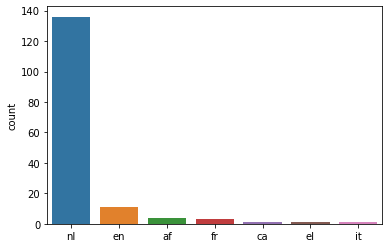

In [7]:
# language fragmentation
sns.countplot(x = test_tweets.rdd.map(lambda x: x[7]).collect())

# Cleaning up the tweet text

In [8]:
# Only keep dutch tweets
test_tweets = test_tweets[test_tweets.lang.isin("nl")]

In [9]:
def form_sentence(tweet):
    tweet_blob = TextBlob(tweet)
    return ' '.join(tweet_blob.words)

In [10]:
translator = Translator()
def safe_translate(tweet):
    lang = detect(tweet)
    if lang == 'en':
        return tweet
    else:
        return translator.translate(tweet, dest="en")

In [11]:
stopw = stopwords.words('english')
def no_user_alpha(tweet):
        tweet_list = [ele for ele in tweet.split() if ele != 'user']
        clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
        clean_s = ' '.join(clean_tokens)
        clean_mess = [word for word in clean_s.split() if word.lower() not in stopw]
        return ' '.join(clean_mess)

In [12]:
lem = spacy.load('nl_core_news_sm')
def lemmatize(tweet):
    normalized_tweet = [token.lemma_ for token in lem(tweet)]
    return ' '.join(normalized_tweet)

In [13]:
udf_form_sentence = udf(form_sentence)
test_tweets = test_tweets.withColumn('text', udf_form_sentence('text'))

print(test_tweets.take(1)[0]['text'])


Leest over hele dure vakanties Een crisisbijeenkomst van ministers blijft uit omdat het Kamerreces nog loopt en sommige ministers op vakantie zijn https t.co/WqBtvIvZ8K


In [14]:
udf_no_user_alpha = udf(no_user_alpha)
test_tweets = test_tweets.withColumn('text', udf_no_user_alpha('text'))
print(test_tweets.take(1)[0]['text'])

Leest hele dure vakanties Een crisisbijeenkomst van ministers blijft uit omdat het Kamerreces nog loopt en sommige ministers op vakantie zijn https


In [15]:
udf_lemmatize = udf(lemmatize)
test_tweets = test_tweets.withColumn('text', udf_lemmatize('text'))
print(test_tweets.take(1)[0]['text'])

leest heel duur vakantie een crisisbijeenkomst van minister blijven uit omdat het kamerrece nog lopen en sommige minister op vakantie zijn http


In [16]:
test_tweets.schema

StructType(List(StructField(tweet_id,StringType,true),StructField(created_at,StringType,true),StructField(name,StringType,true),StructField(text,StringType,true),StructField(location,StringType,true),StructField(tags,StringType,true),StructField(label,IntegerType,true),StructField(lang,StringType,true)))

In [17]:
# Define the pipeline

pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer='word')),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [18]:
from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer(inputCol="text", outputCol="features")
# Countvectorizer expect an array of strings, not string
test_tweets_cast = test_tweets.withColumn("text", split(F.col("text"), " ").cast("array<string>"))

model = cv.fit(test_tweets_cast)

result = model.transform(test_tweets_cast)
result.show(truncate=False)

+-------------------+-------------------+-----------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------+--------------------------+-----+----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tweet_id           |created_at         |name                         |text                                                                                                                                                                                                                                                                  |location            

In [34]:
data = test_tweets.select("text",'label').rdd


In [51]:
X = test_tweets.select("text").rdd.flatMap(lambda x: x).collect()
y = test_tweets.select("label").rdd.flatMap(lambda x: x).collect()

In [52]:
print(len(X), len(y))

135 134


In [21]:
msg_train, msg_test, label_train, label_test = train_test_split(X, y, test_size=0.2)
pipeline.fit(msg_train,label_train)
predictions = pipeline.predict(msg_test)

ValueError: Found input variables with inconsistent numbers of samples: [134, 135]

In [18]:
print(classification_report(predictions,label_test))

print(accuracy_score(predictions,label_test))

              precision    recall  f1-score   support

           0       1.00      0.44      0.62        27
           1       0.00      0.00      0.00         0

    accuracy                           0.44        27
   macro avg       0.50      0.22      0.31        27
weighted avg       1.00      0.44      0.62        27

0.4444444444444444


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


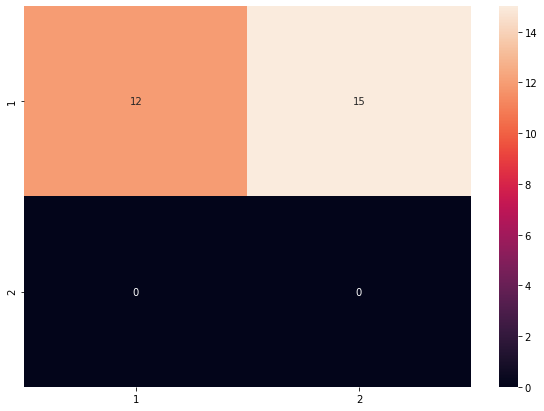

In [19]:
conf = confusion_matrix(predictions,label_test)
plt.figure(figsize = (10,7))
df_cm = pd.DataFrame(conf, index = [i for i in "12"],
                  columns = [i for i in "12"])
sns.heatmap(df_cm, annot=True)